In [1]:
import os 

running_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/"
os.chdir(running_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import yaml
from IPython.display import Markdown, display
from omegaconf import OmegaConf
from hydra.utils import call, instantiate
from pytorch_lightning import Trainer

import torch.nn as nn
import src.differentiable_fonc as DF
from src.utils import *




In [3]:
plt.style.use('ggplot')

In [4]:
cmap = plt.get_cmap('viridis')

In [5]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [6]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = None
    old_n_components = 0
    print("Initializing datamodule")

Initializing datamodule


In [7]:
save_fig = False

## Functions

In [8]:
def plot_imgs_depth_lon_2D(ssp_truth_unorm_test_arr,
                           ssp_pca_unorm_test_arr,
                           ssp_ae_unorm_test_arr, 
                           ecs_truth, 
                           ecs_pred_pca, 
                           ecs_pred_ae, 
                           depth_array,
                           coords,
                           n_components, 
                           compression_rate_pca, 
                           compression_rate_ae, 
                           bottleneck_shape):
    
    fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].imshow(ssp_truth_unorm_test_arr, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(ssp_pca_unorm_test_arr, cmap=cmap, aspect = "equal")
    im3 = axs[2].imshow(ssp_ae_unorm_test_arr, cmap=cmap, aspect = "equal")


    y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
    y_tick_values = depth_array[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]

        
        
        
    indices_ecs_truth = np.searchsorted(depth_array, ecs_truth.detach().cpu().numpy())
    indices_ecs_pca = np.searchsorted(depth_array, ecs_pred_pca.detach().cpu().numpy())
    indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae.detach().cpu().numpy())


    axs[0].plot(indices_ecs_truth, label = "ECS")
    axs[1].plot(indices_ecs_pca, label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_pca)**2)).item(),2)}m")
    axs[2].plot(indices_ecs_ae, label = f"ECS RMSE ={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_ae)**2)).item(),2)}m")

    for ax in axs[:]:
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")
        
        #ax.invert_yaxis() 

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\n{n_components} depth components, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_pca_unorm_test_arr)**2)/np.sum(ssp_truth_unorm_test_arr**2))*100,8)}%", fontsize = 10)
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_ae_unorm_test_arr)**2)/np.sum(ssp_truth_unorm_test_arr**2))*100,8)}%", fontsize = 10)

    axs[0].set_ylabel('Depth (m)')


    cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("m/s")

    min_val, max_val = im3.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()

    fig.suptitle(f"Sound Speed reconstruction",x = 0.45, y = 0.80)


## Model without training

params:

            save_dir_name=$save_dir \
            trainer.max_epochs=$max_epoch \
            datamodule.depth_pre_treatment.method=$pre_treatment_method \
            datamodule.depth_pre_treatment.params=$n_components \
            model_config.model_hparams.AE_CNN_3D.channels_list=$chnls \
            model_config.model_hparams.AE_CNN_3D.n_conv_per_layer=1 \
            model_config.model_hparams.AE_CNN_3D.padding=reflect \
            model_config.model_hparams.AE_CNN_3D.interp_size=25 \
            model_config.model_hparams.AE_CNN_3D.upsample_mode=trilinear \
            model_config.model_hparams.AE_CNN_3D.pooling_dim=spatial \
            model_config.model_hparams.AE_CNN_3D.act_fn_str=Relu \
            model_config.model_hparams.AE_CNN_3D.final_act_fn_str=Relu \
            model.opt_fn.lr=0.001 \
            model.loss_weight.prediction_weight=$pred_weight \
            model.loss_weight.gradient_weight=$grad_weight \
            model.loss_weight.ecs_weight=$ecs_weight \
            model.loss_weight.fft_weight=$fft_weight \
            model.loss_weight.weighted_weight=$weighted_weight \

In [9]:
# from datetime import datetime
# def now_resolver(value: str):
#     # Check if the value is in the format ${now:%Y-%m-%d_%H-%M}
#     if value.startswith('${now:') and value.endswith('}'):
#         # Extract the datetime format
#         format_string = value[6:-1]  # Extract part after '${now:' and before '}'
#         return datetime.now().strftime(format_string)
#     return value  # Return the value unchanged if not a 'now' placeholder

In [10]:


cfg_path = "config/xp/autoencoder_V2.yaml"
cfg = OmegaConf.load(cfg_path)
display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

```yaml

datamodule:
  _target_: src.autoencoder_datamodule.AutoEncoderDatamodule_${dimensions}
  depth_pre_treatment: {method: none, params: 1}
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 2}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssp_da, ssf_da_path: '${paths.sound}'}
  manage_nan: suppress
  n_profiles: null
  norm_stats: {method: mean_std, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 3D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dim: '${dimensions}', dm: '${datamodule}', lit_mod: '${model}',
  trainer: '${trainer}'}
hydra:
  job:
    env_set: {CUDA_VISIBLE_DEVICES: 1}
  run: {dir: '${trainer.logger.save_dir}/${trainer.logger.name}/${trainer.logger.version}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  dim: ${dimensions}
  loss_weight: {ecs_weight: 0, fft_weight: 0, gradient_weight: 0, inflection_pos_weight: 0,
    inflection_value_weight: 0, max_position_weight: 0, max_value_weight: 0, prediction_weight: 0.5,
    weighted_weight: 1}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.utils.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.001}
model_architecture: AE_CNN
model_config:
  accumulate_grad_batches: {1D: 1, 2D: 1, 3D: 1}
  batch_size: {1D: 512, 2D: 32, 3D: 4}
  model_hparams:
    AE_CNN_1D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 9
      linear_layer: false
      n_conv_per_layer: 1
      padding: linear
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_2D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_3D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
  save_dir: {AE_CNN: 'pooling_${model.model_hparams.pooling}_on_dim_${model.model_hparams.pooling_dim}/channels_${model.model_hparams.channels_list}/upsample_mode_${model.model_hparams.upsample_mode}/linear_later_${model.model_hparams.linear_layer}_lattent_size_${model.model_hparams.latent_size}/${model.model_hparams.n_conv_per_layer}_conv_per_layer/padding_${model.model_hparams.padding}/interp_size_${model.model_hparams.interp_size}/final_upsample_${model.model_hparams.final_upsample_str}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}',
    AE_CNN_pool_1D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}',
    AE_CNN_pool_2D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}_normalization_${datamodule.norm_stats.method}'}
normalization:
  mean_std: {mean: null, std: null}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: null, x_min: null}
paths: {sound: /Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc}
patience: 5
root_save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs"
save_dir_name: test
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, min_delta: 1.0e-06, monitor: val_loss,
    patience: '${trainer.max_epochs}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: true,
    name: '${save_dir_name}', save_dir: '${root_save_dir}/AE/${model.model_name}',
    version: 'pred_${model.loss_weight.prediction_weight}_grad_${model.loss_weight.gradient_weight}_max_pos_${model.loss_weight.max_position_weight}_max_value_${model.loss_weight.max_value_weight}_fft_${model.loss_weight.fft_weight}_weighted_${model.loss_weight.weighted_weight}_inflection_pos_${model.loss_weight.inflection_pos_weight}_inflection_value_${model.loss_weight.inflection_value_weight}/depth_pre_treatment_${datamodule.depth_pre_treatment.method}_n_components_${datamodule.depth_pre_treatment.params}/${model_config.save_dir.${model_architecture}}/lr_${model.opt_fn.lr}/normalization_${datamodule.norm_stats.method}/manage_nan_${datamodule.manage_nan}/n_profiles_${datamodule.n_profiles}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 1


```

In [11]:
trainer = Trainer(inference_mode = True)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/Odyssey/private/o23gauvr/miniconda3/envs/fsc_env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Odyssey/private/o23gauvr/miniconda3/envs/fsc_env/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
dm_dict = cfg.datamodule
dm = call(dm_dict) #hydra.utils.call(dm_dict)
train_ssp_tens, test_ssp_tens, dm, coords = loading_datamodule(dm)

In [13]:
# channels_list = [[1,8],[1,8,8],[1,8,8,8],[1,8,8,8,8]]

# for chn in channels_list: 
#     cfg.model.model_hparams.channels_list = chn
#     lit_mod = call(cfg.model)

#     trainer.test(lit_mod, dataloaders=dm)

#     checkpoint_path = f"{cfg.trainer.logger.save_dir}/untrained_models/{cfg.model_config.save_dir[f'{cfg.model_architecture}']}"
#     os.makedirs(checkpoint_path, exist_ok=True)

#     model_path = f"{checkpoint_path}/model.ckpt"
#     torch.save(lit_mod.state_dict(), model_path)
#     print(f"Model checkpoint saved at {checkpoint_path}")


# Only pool upsample model

In [14]:
class NoConvAE(nn.Module):
    def __init__(self, 
                 n:int, 
                 pooling_dim:str = "spatial",
                 pooling_mode:str = "Avg"):


        super().__init__()

        self.upsample_mode = "trilinear"


        if pooling_dim == "all":
            pool_str = 2
            
        elif pooling_dim == "depth":
            pool_str = (2,1,1)

        elif pooling_dim == "spatial":
            pool_str = (1,2,2)
        
        elif pooling_dim == None:
            pool_str = 1




        pooling_dict = {"Avg": nn.AvgPool3d(kernel_size= 1,stride=pool_str, padding = 0),
                        "Max": nn.MaxPool3d(kernel_size=1, stride=pool_str, padding = 0),
                        "None": nn.Identity()}     
        
        upsample_dict = {"Avg": nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "Max":  nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "None": nn.Identity()}   
        
        pool_layer = pooling_dict[pooling_mode]
        upsample_layer = upsample_dict[pooling_mode]

            

        self.encoder = nn.Sequential(*[pool_layer for i in range(n)])
    
        self.decoder = nn.Sequential(*[upsample_layer for i in range(n-1)])

        self.decoder.append(nn.Upsample(size=None, mode=self.upsample_mode))

    
    def forward(self,x):

        self.decoder[-1].size = x.shape[-3:]

        x = x.unsqueeze(1)

        self.bottleneck = self.encoder(x)

        self.output = self.decoder(self.bottleneck).squeeze(1)
    

        return self.output

        




In [15]:
unorm = True

if unorm:
    test_ssp_tens = torch.tensor(unorm_ssp_arr_3D(test_ssp_tens.cpu().numpy(), dm)).to(device)

  0%|          | 0/5 [00:00<?, ?it/s]

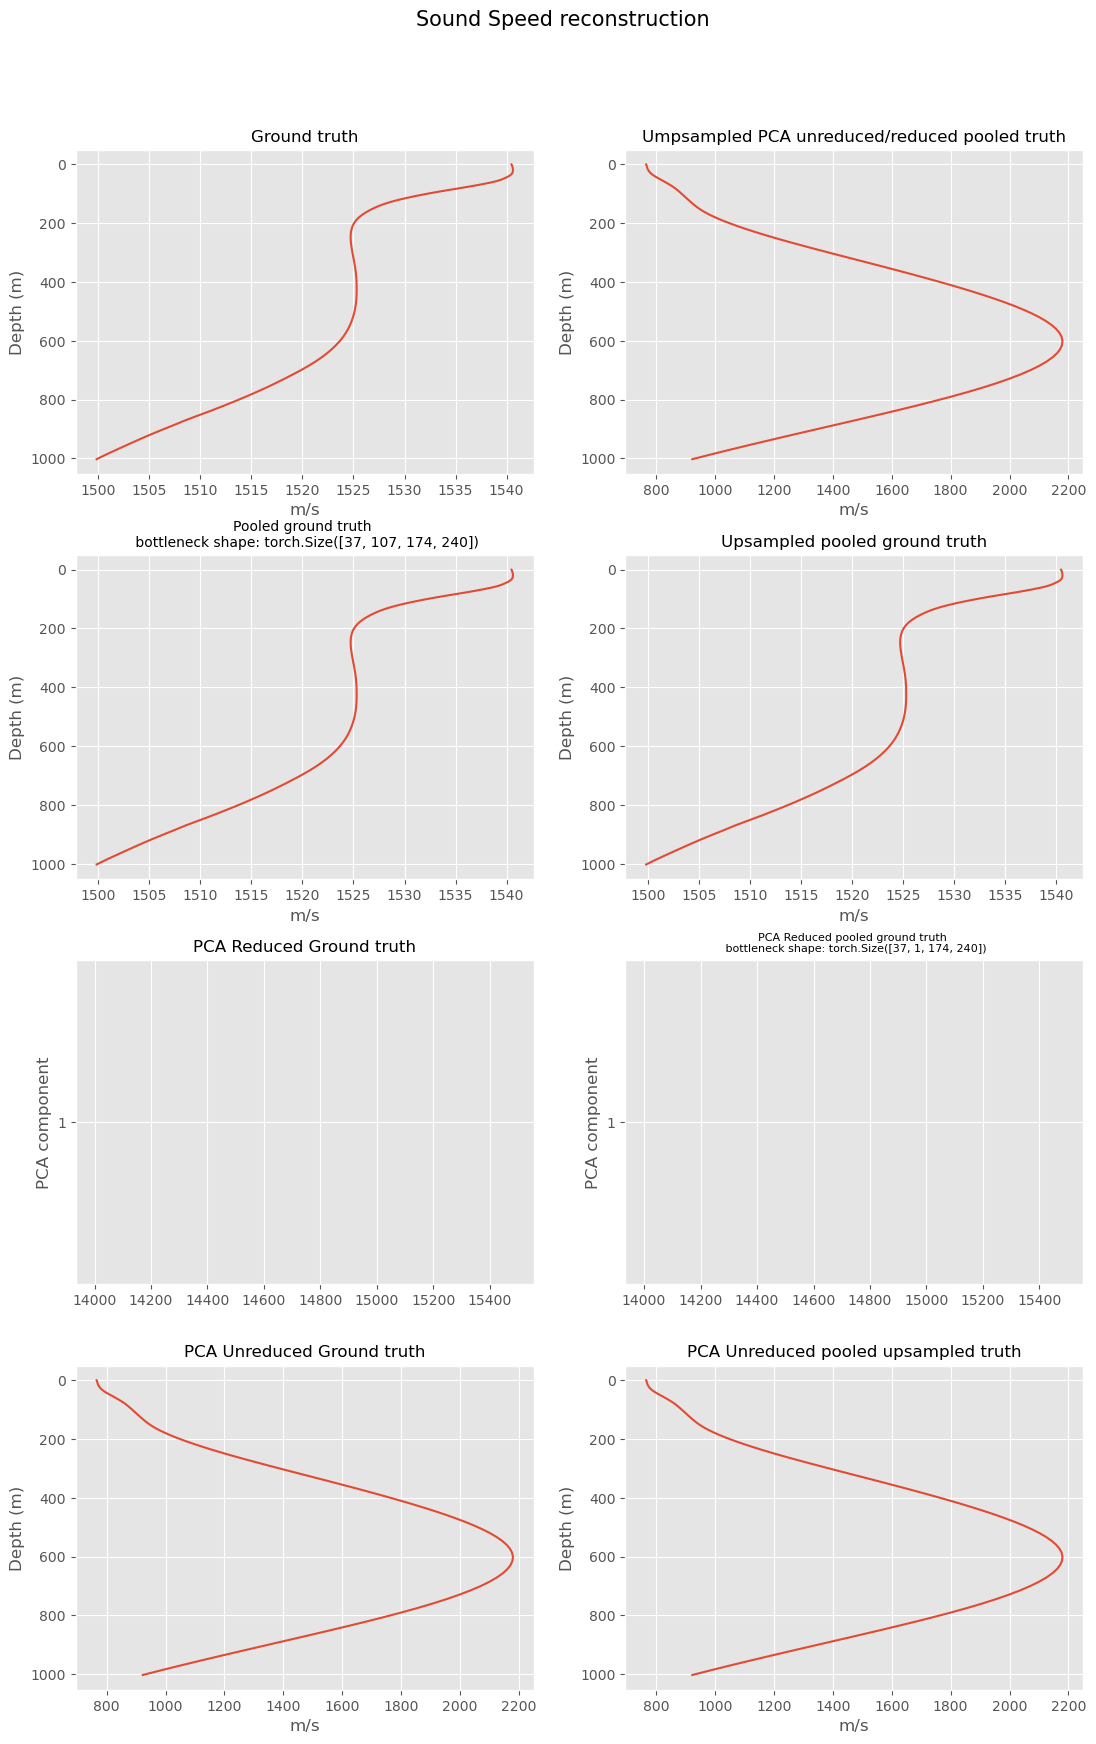

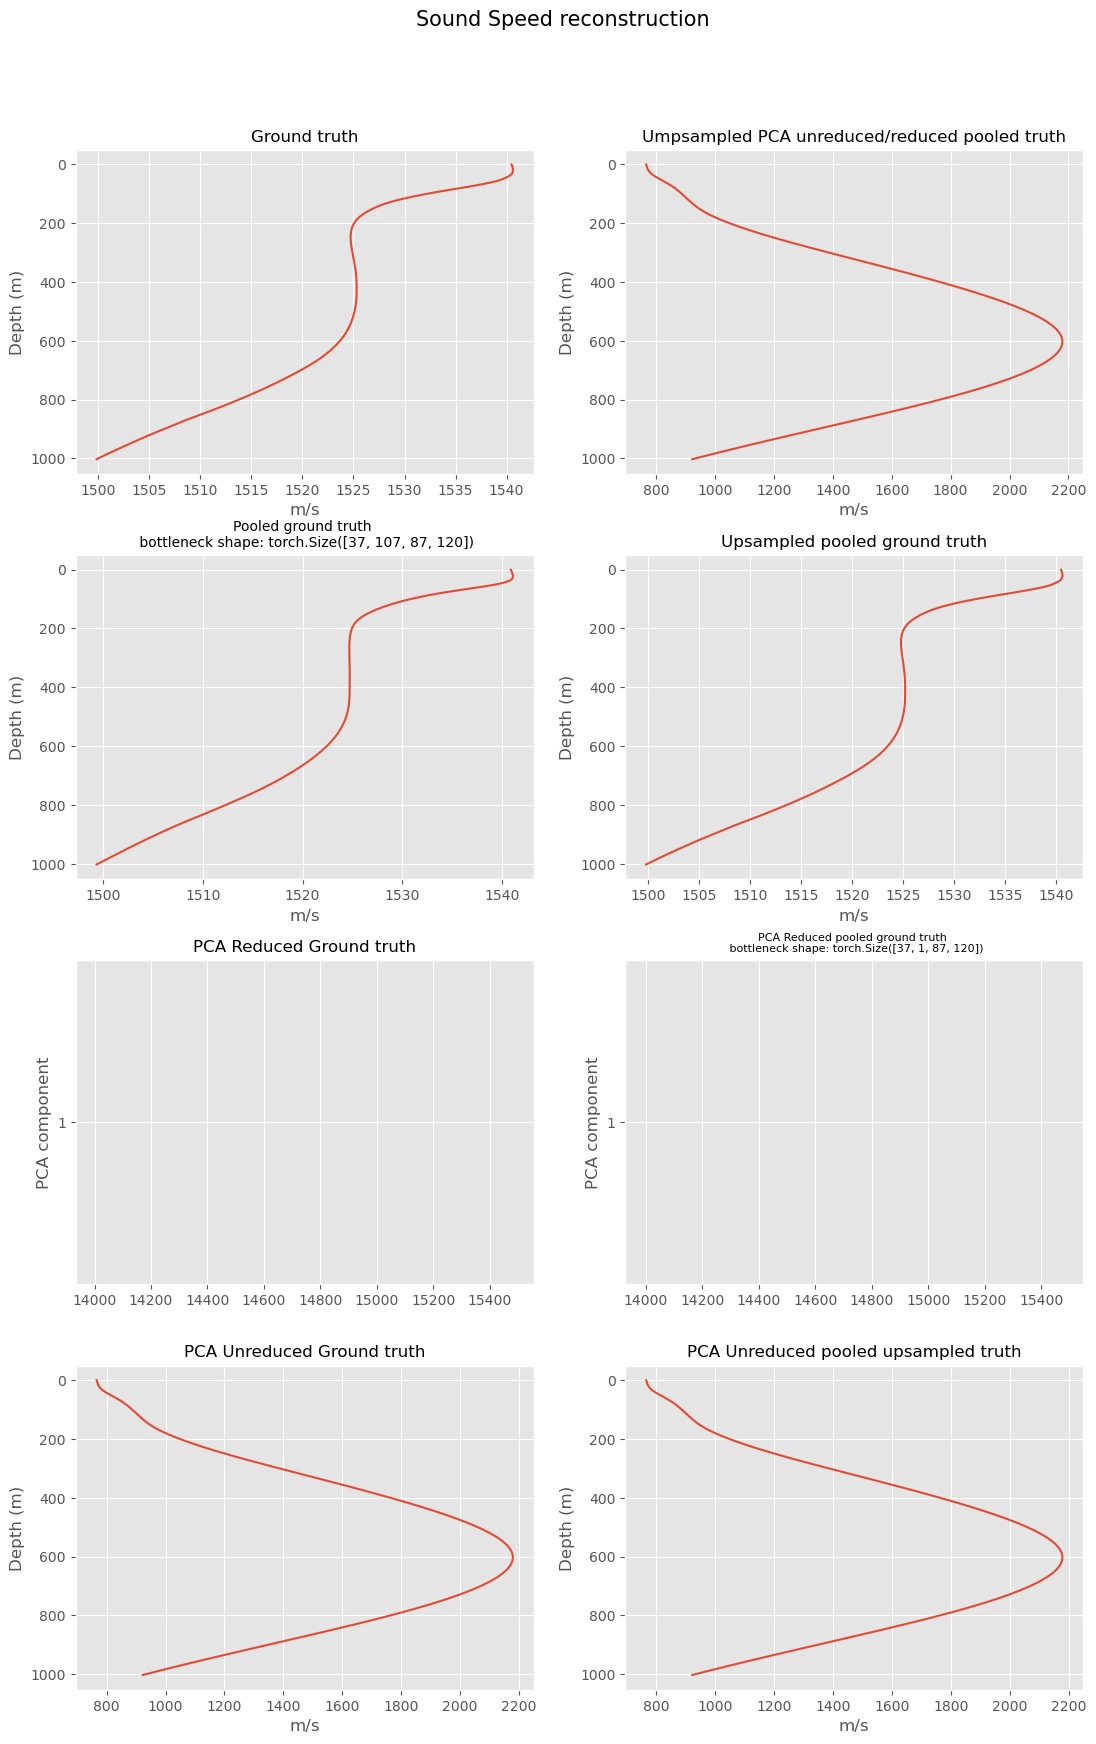

 20%|██        | 1/5 [00:31<02:05, 31.30s/it]

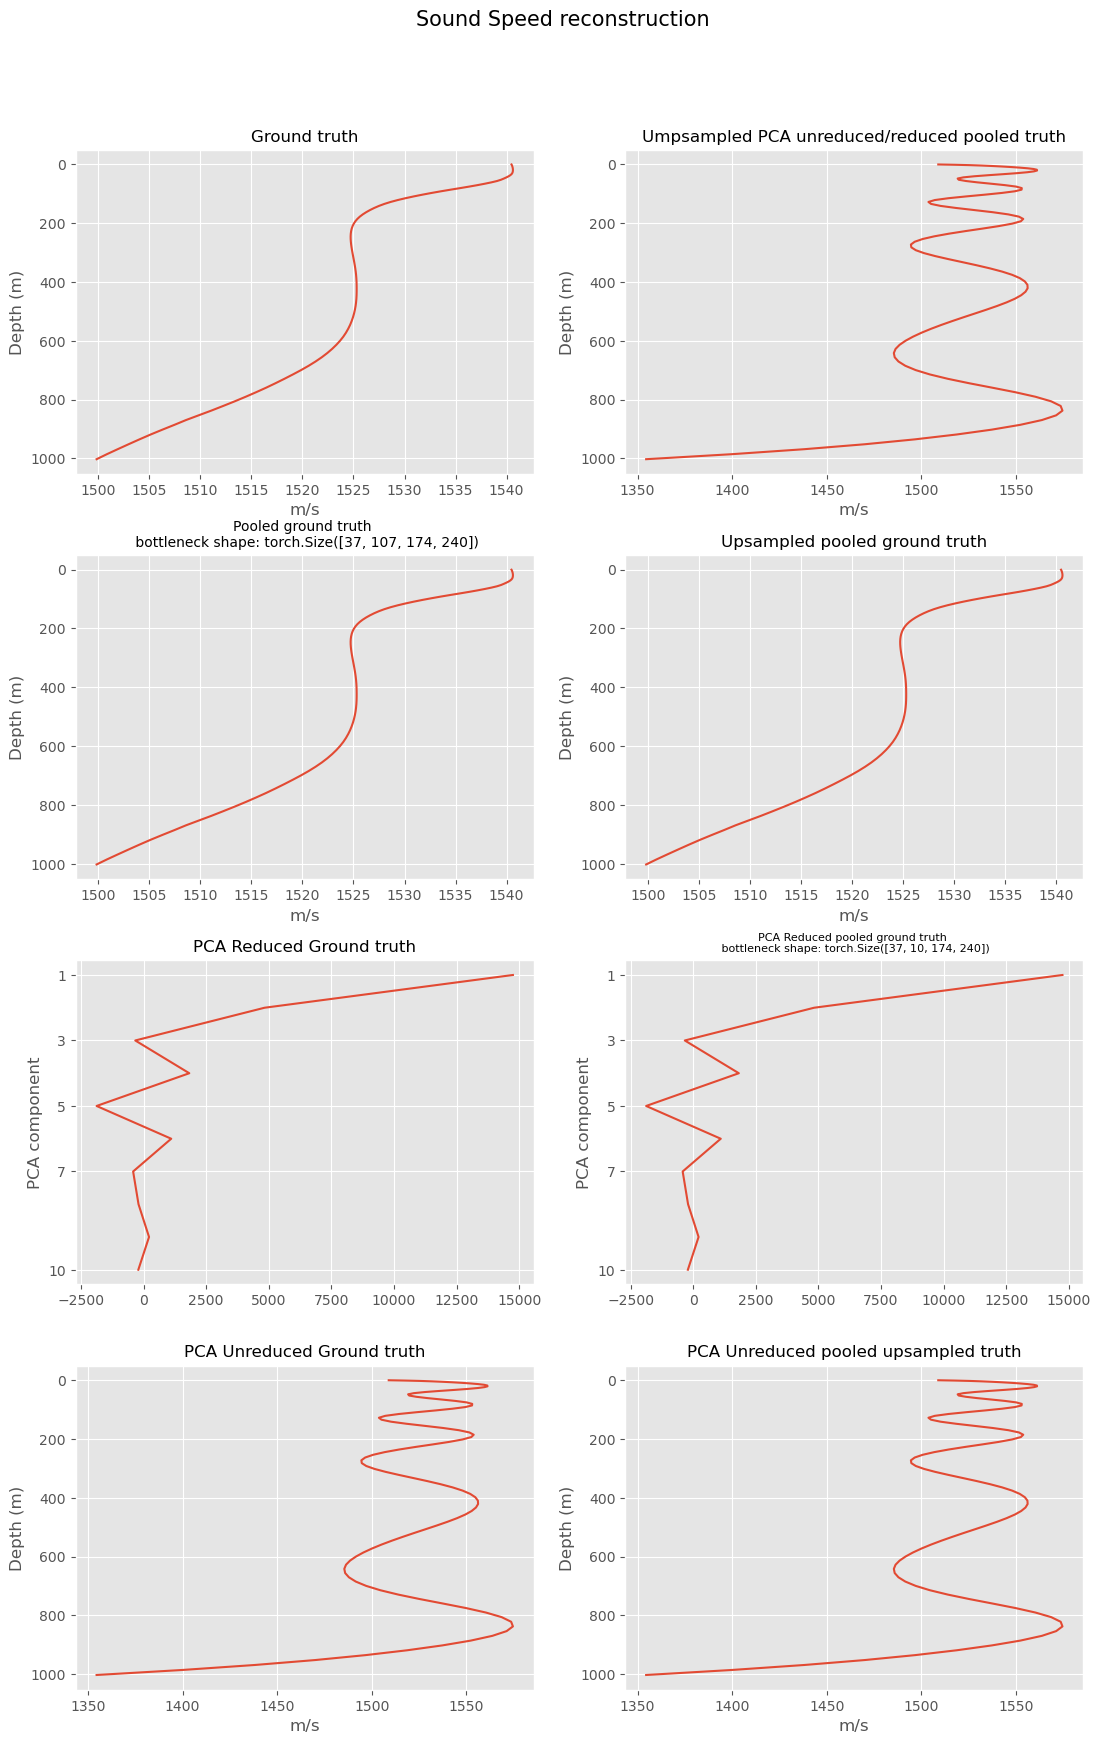

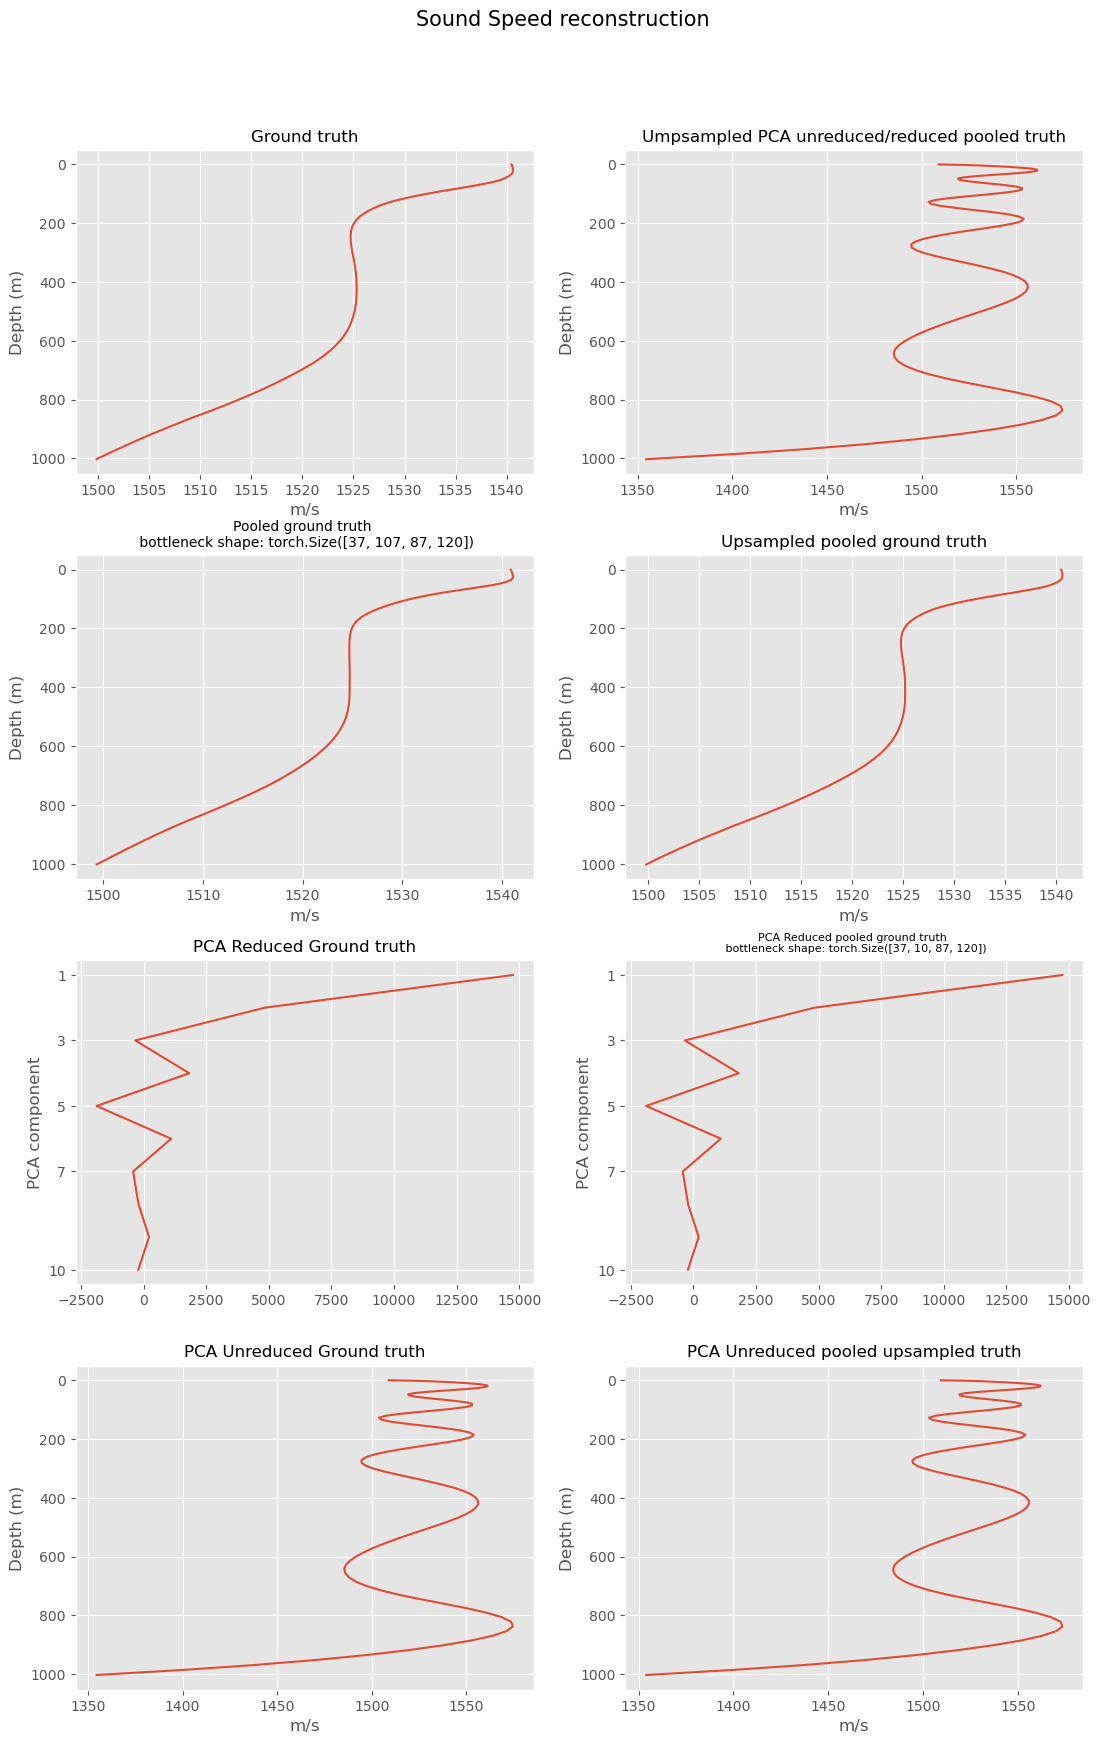

 40%|████      | 2/5 [01:03<01:34, 31.66s/it]

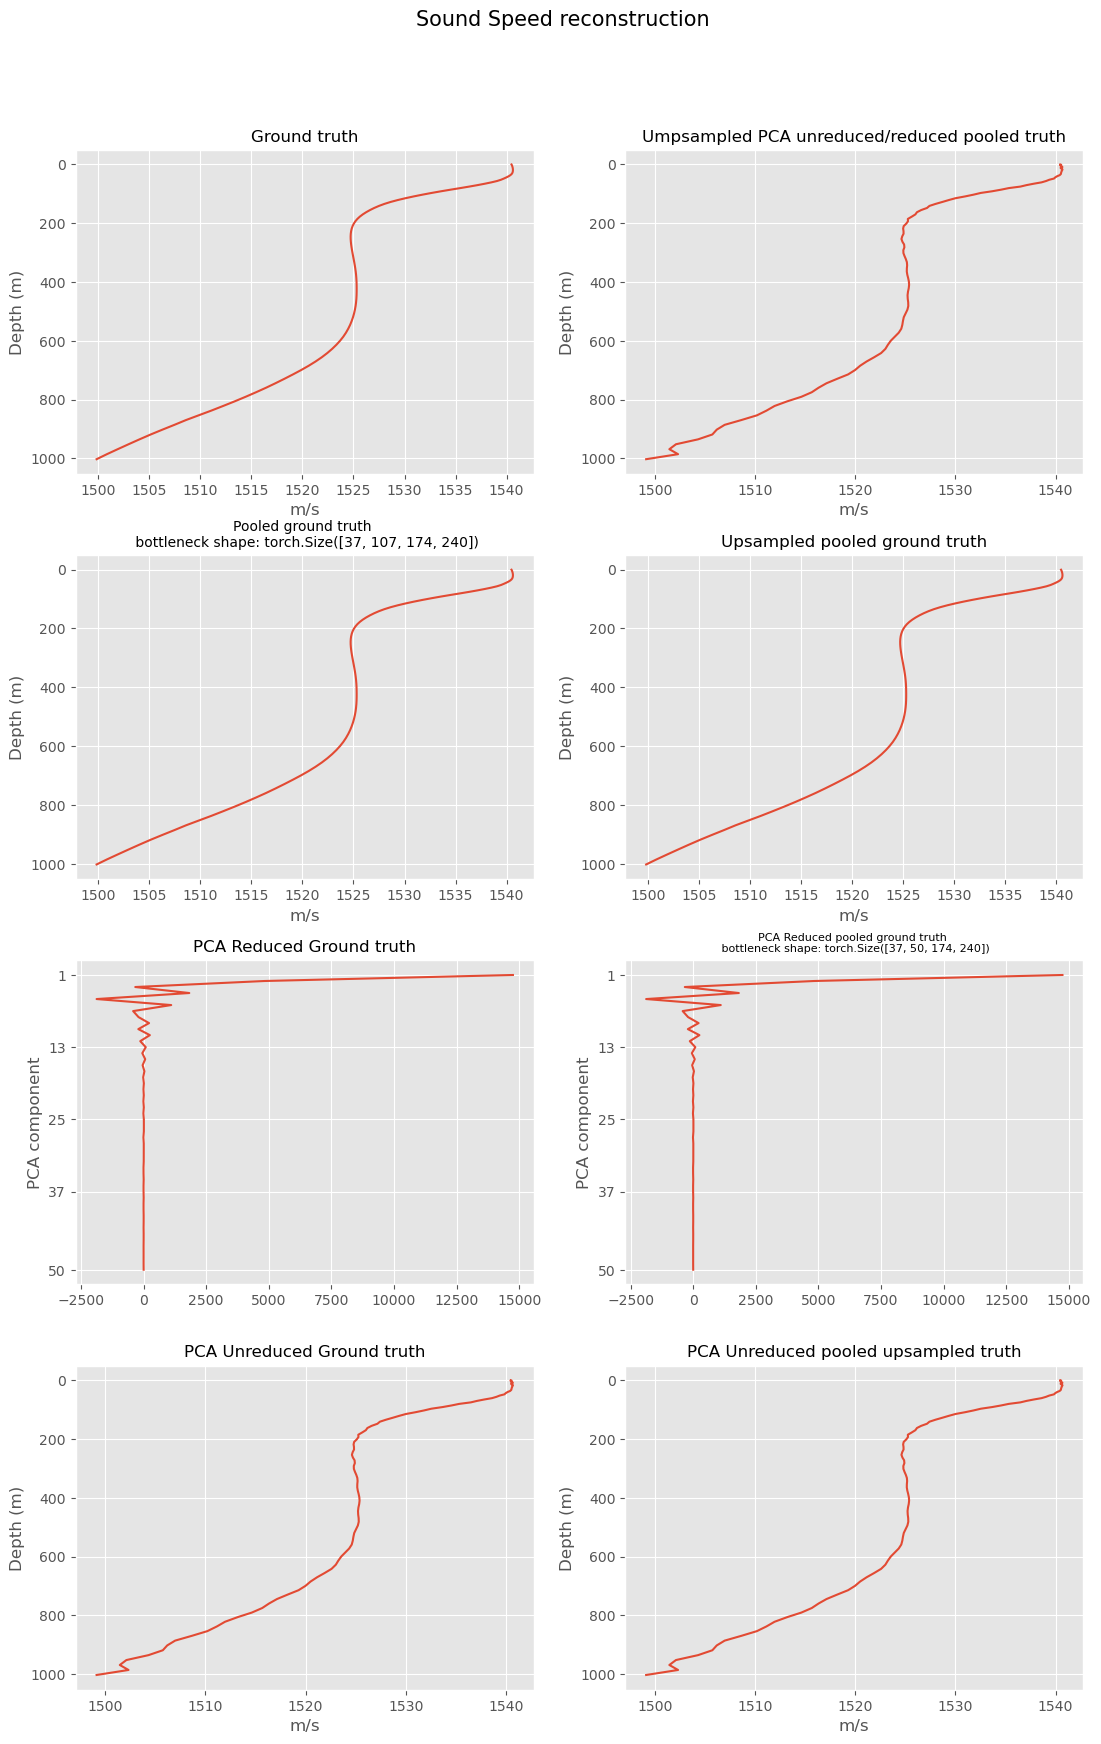

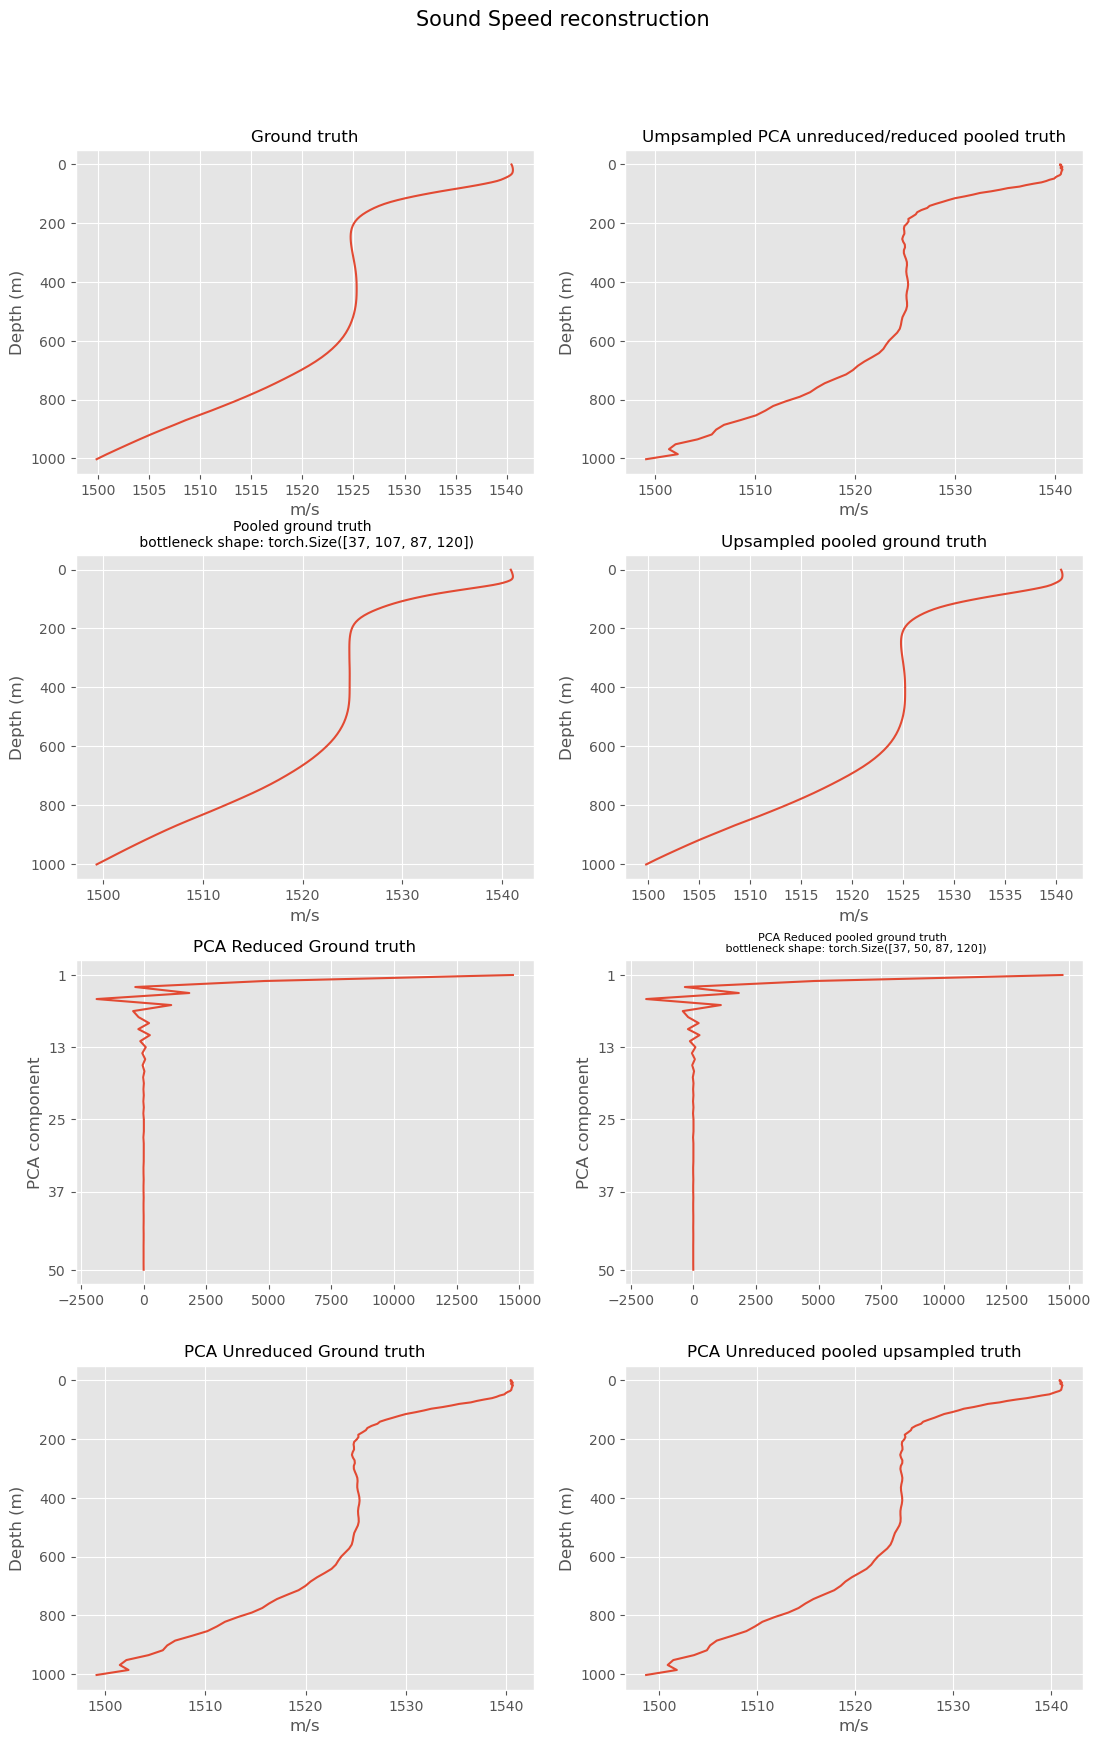

 60%|██████    | 3/5 [01:33<01:02, 31.09s/it]

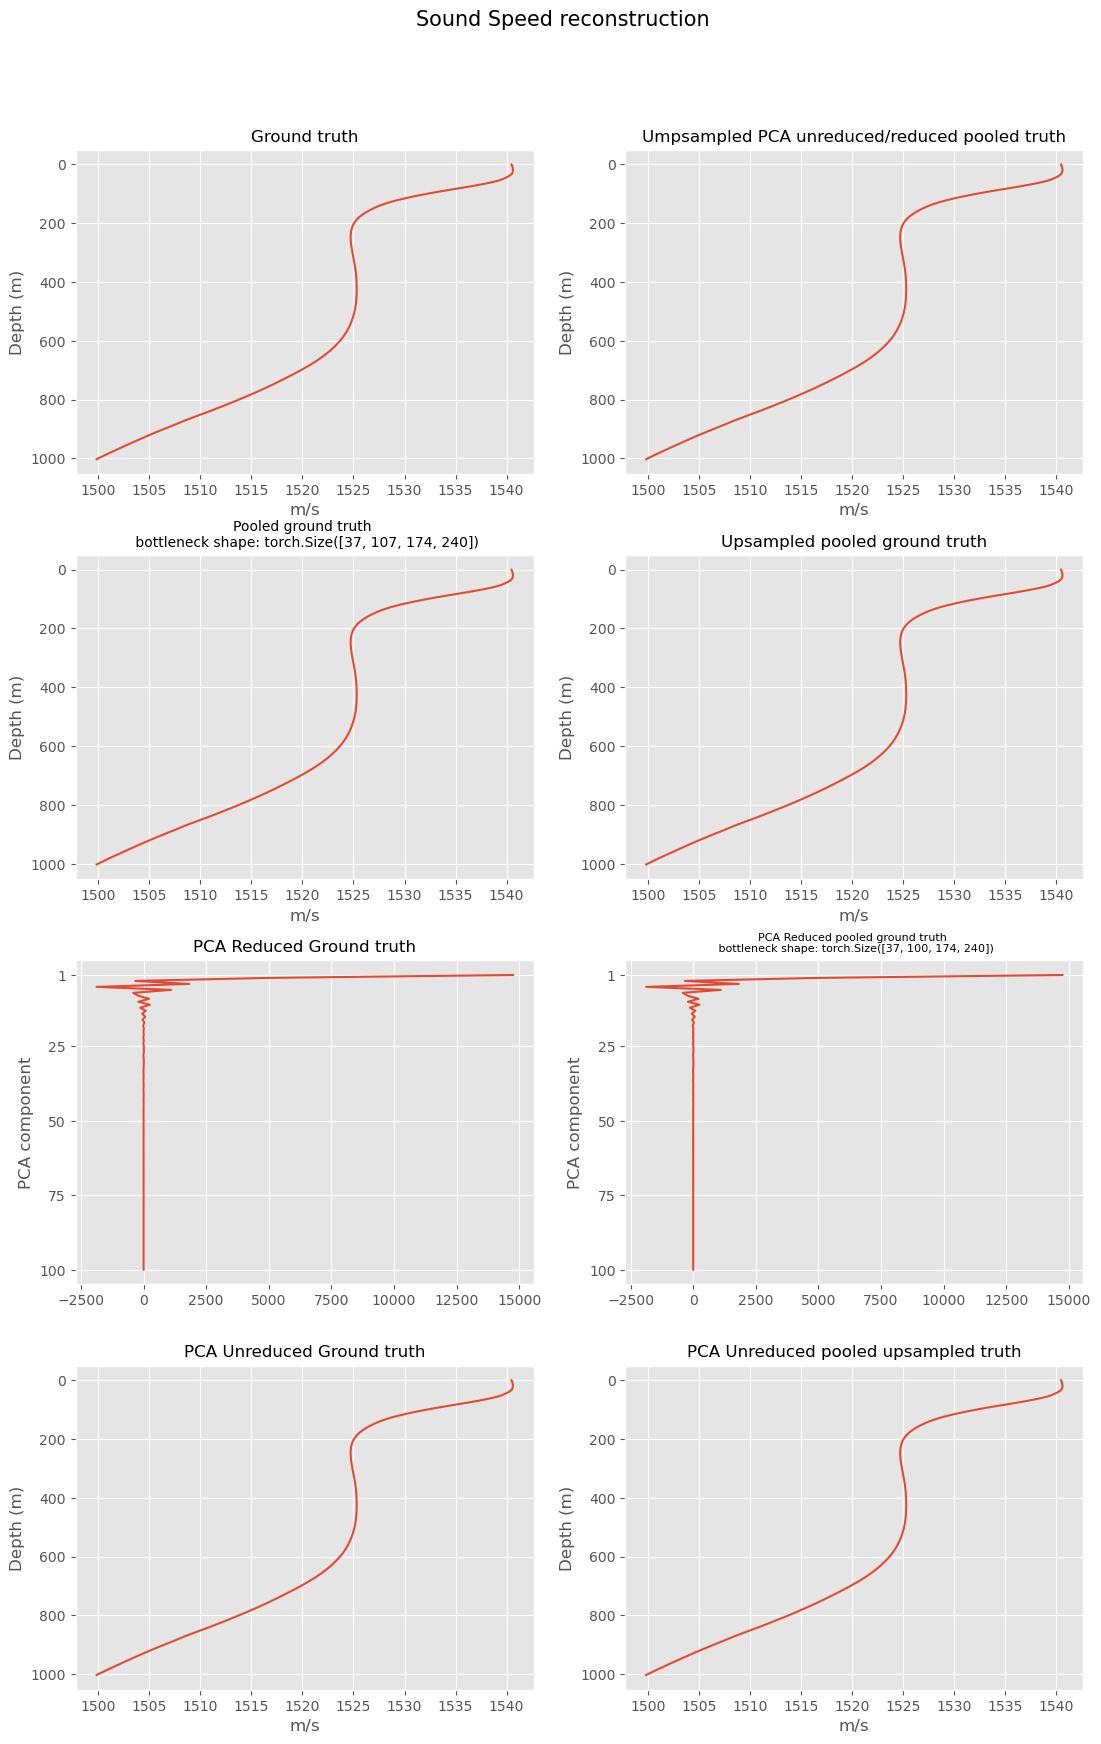

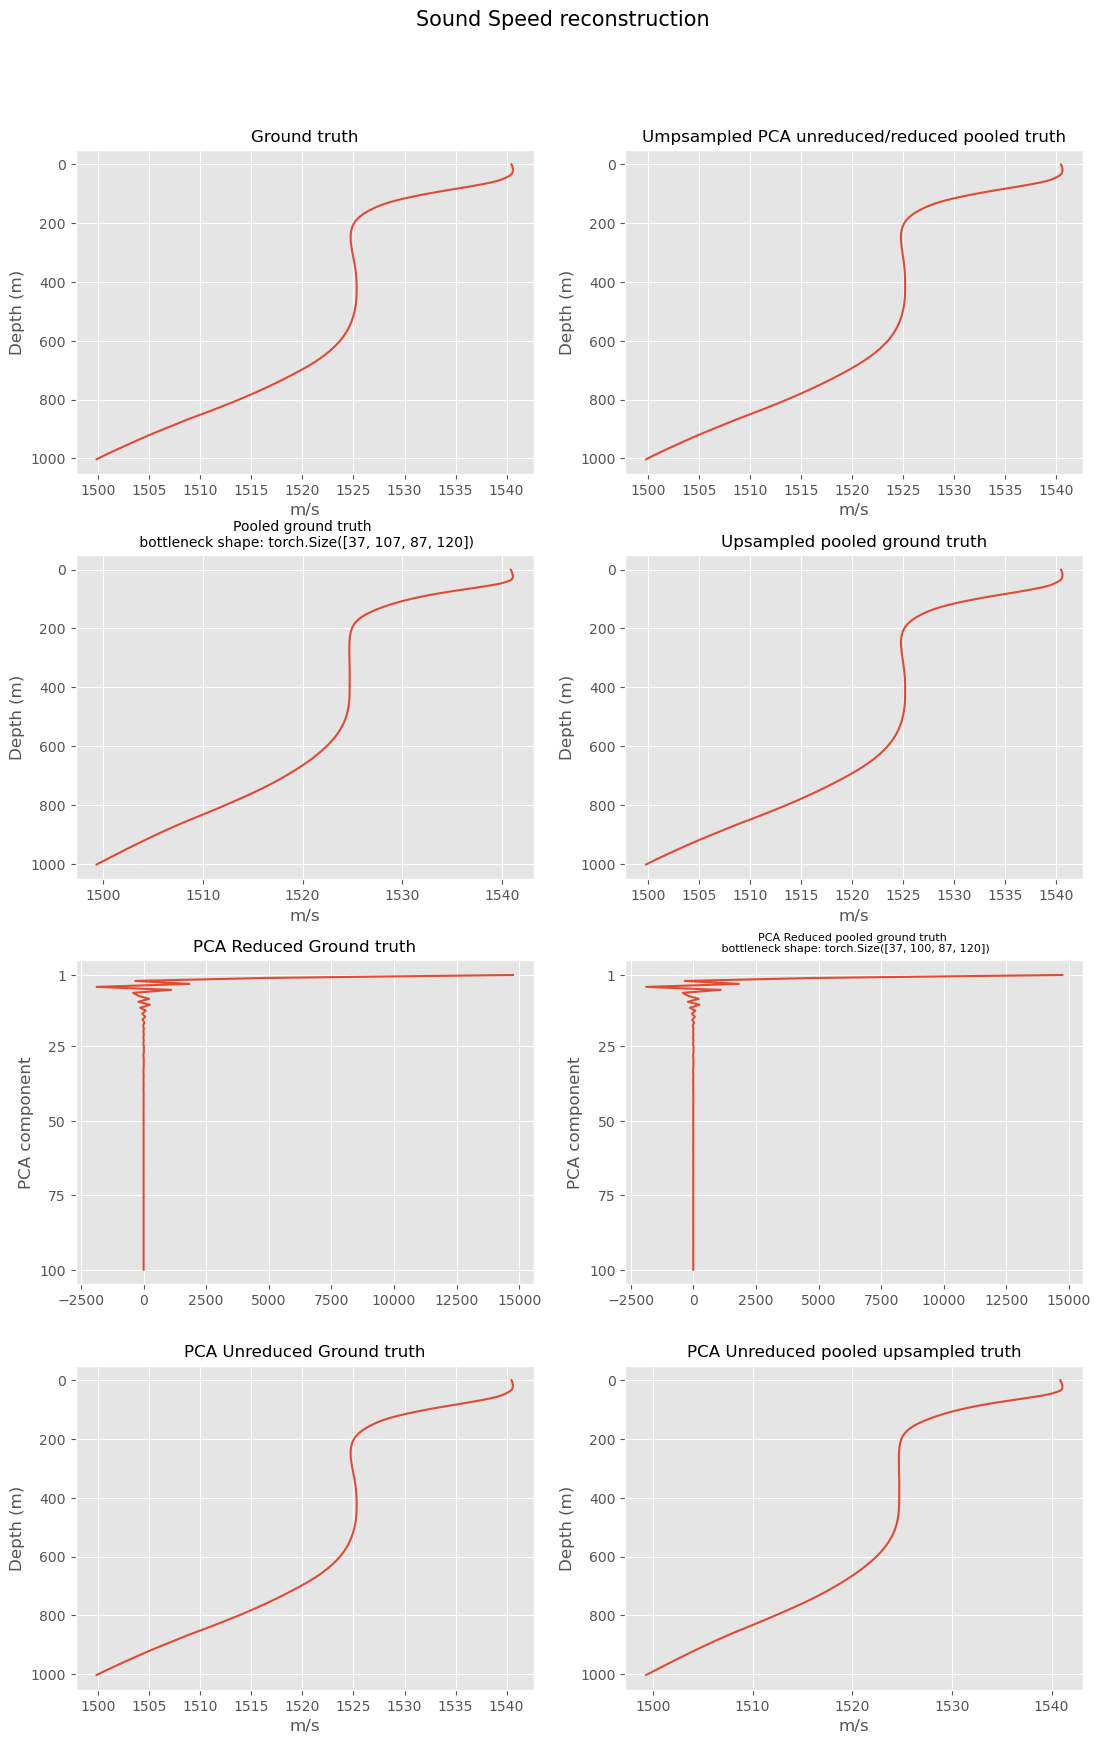

 80%|████████  | 4/5 [02:07<00:32, 32.17s/it]

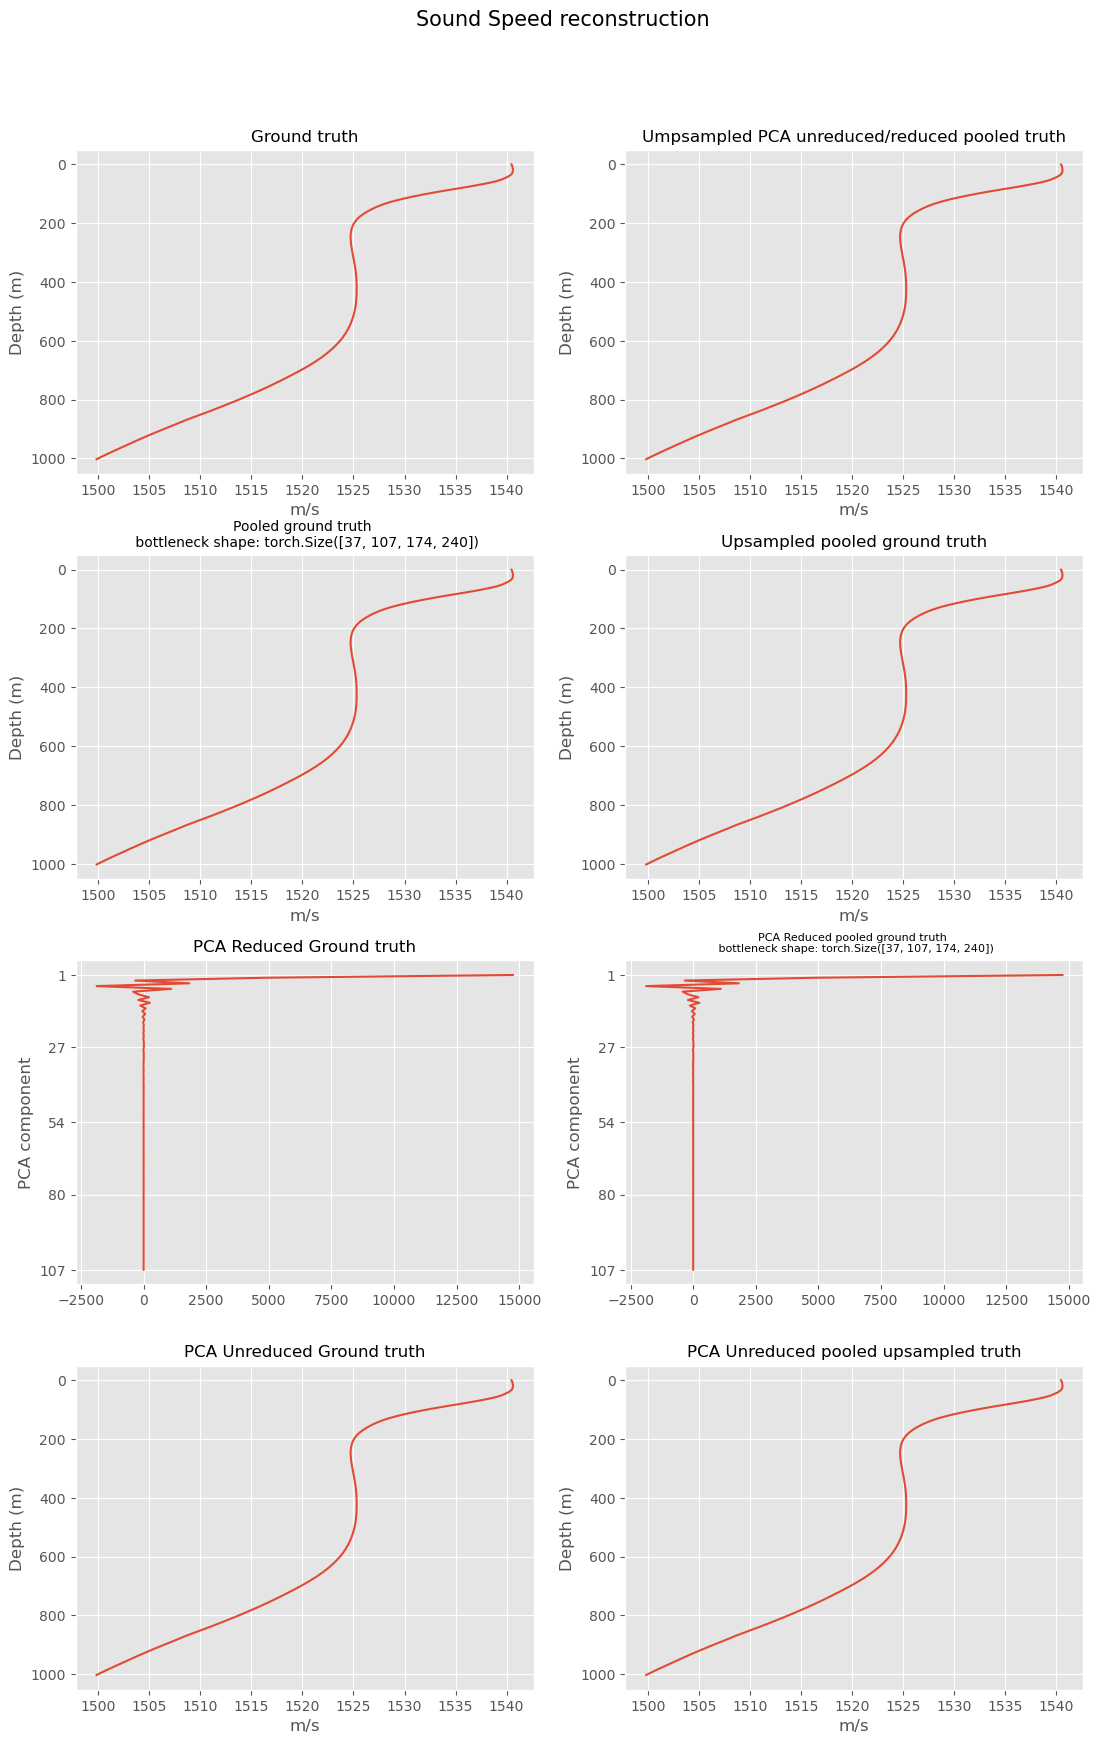

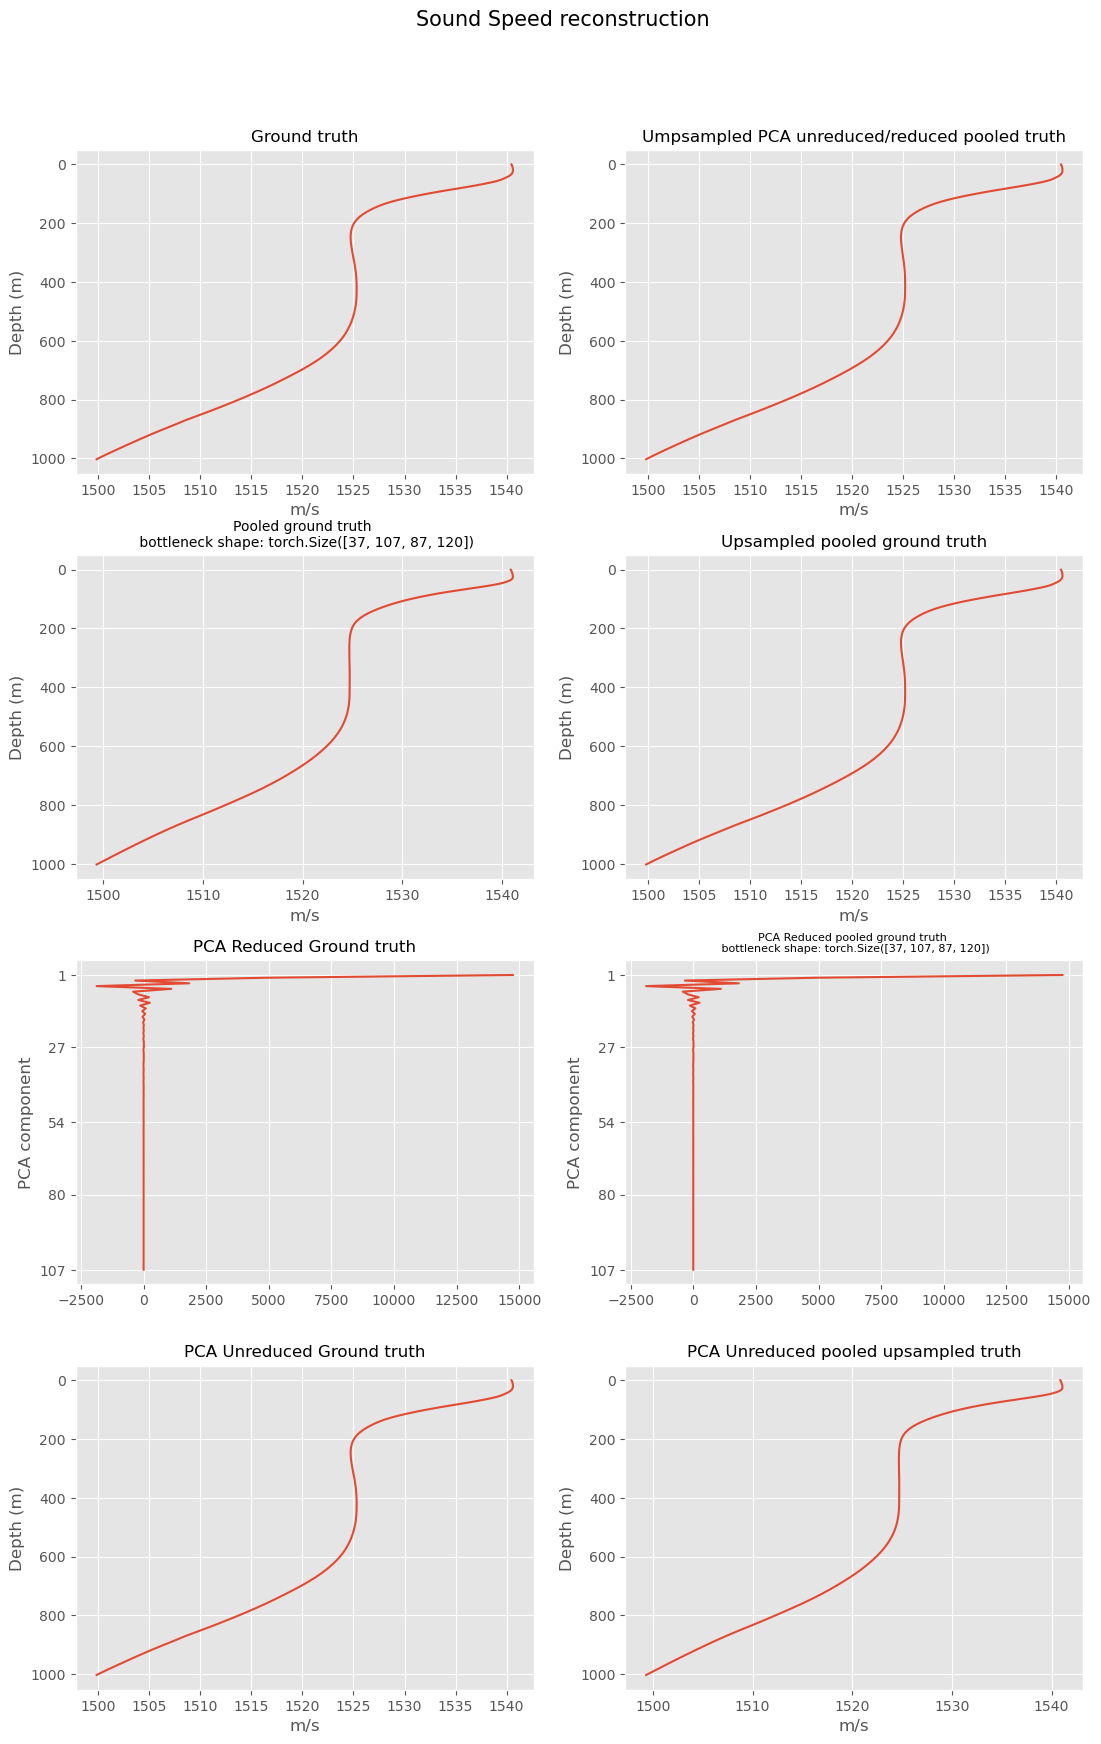

100%|██████████| 5/5 [02:42<00:00, 32.40s/it]


In [37]:

t, lat = 10, 10
lon = 10

pca_list = [1, 10, 50, 100, 107] #np.arange(107,108) 

ae_rmse_dict = {"SSP":{},
                "ECS":{}}



for n_components in tqdm(pca_list):

    input_shape = test_ssp_tens.shape
    pca = PCA(n_components = n_components, svd_solver = 'auto')
    pca.fit(train_ssp_tens.permute(0,2,3,1).reshape(-1,input_shape[1]))
    
    dif_pca = DF.Differentiable4dPCA(pca, test_ssp_tens.shape, device, dtype=test_ssp_tens.dtype) #test_ssp_tens.shape

    pca_reduced_test_ssp_tens = dif_pca.transform(test_ssp_tens) #test_ssp_tens
    pca_unreduced_test_ssp_tens = dif_pca.inverse_transform(pca_reduced_test_ssp_tens)

    pca_test = pca.inverse_transform(pca.transform(test_ssp_tens.detach().cpu().numpy().transpose(0,2,3,1).reshape(-1,input_shape[1]))).reshape(input_shape[0],input_shape[2],input_shape[3],input_shape[1]).transpose(0,3,1,2)
    assert torch.allclose(torch.tensor(pca_test,dtype=test_ssp_tens.dtype), pca_unreduced_test_ssp_tens, atol=1e-6), "PCA transformation is not consistent"
    
    for keys in ae_rmse_dict.keys():
        ae_rmse_dict[keys][f"Pool_upsample_pca_{n_components}"] = {}

    for n_layer in tqdm(range(2)): 

        model_ae = NoConvAE(n_layer, pooling_dim="spatial", pooling_mode="Avg")
        

        unreduced_pred_ssp_tens = model_ae(test_ssp_tens)
        reduced_pred_ssp_tens = model_ae.bottleneck.squeeze(1)
        reduced_bottleneck_shape = reduced_pred_ssp_tens.shape


 
        dif_pca.original_shape = reduced_bottleneck_shape
        pca_reduced_pred_ssp_tens = dif_pca.transform(reduced_pred_ssp_tens)
        pca_reduced_bottleneck_shape = pca_reduced_pred_ssp_tens.shape
        pca_unreduced_pred_ssp_tens = dif_pca.inverse_transform(pca_reduced_pred_ssp_tens)
        pred_ssp_tens = model_ae.decoder(pca_unreduced_pred_ssp_tens.unsqueeze(1)).squeeze(1)   

                


        max_ssp_truth_idx = torch.tensor(np.nanargmax(test_ssp_tens.cpu().numpy(), axis=1))
        ecs_truth = dm.depth_array[max_ssp_truth_idx]        

        max_ssp_pred_idx = torch.tensor(np.nanargmax(pred_ssp_tens.cpu().numpy(), axis=1))
        ecs_pred = dm.depth_array[max_ssp_pred_idx]
        
        ae_rmse_dict["SSP"][f"Pool_upsample_pca_{n_components}"][pca_reduced_bottleneck_shape] = torch.sqrt(torch.mean((test_ssp_tens - pred_ssp_tens) ** 2)).item()
        ae_rmse_dict["ECS"][f"Pool_upsample_pca_{n_components}"][pca_reduced_bottleneck_shape] = np.sqrt(np.mean((ecs_truth - ecs_pred) ** 2))


        fig, axs = plt.subplots(4, 2, figsize=(13, 20))

        axs[0, 0].plot(test_ssp_tens[t, :, lat, lon], dm.depth_array)  
        axs[0, 1].plot(pred_ssp_tens[t, :, lat, lon], dm.depth_array)
        axs[1, 0].plot(reduced_pred_ssp_tens[t, :, lat, lon], dm.depth_array)  
        axs[1, 1].plot(unreduced_pred_ssp_tens[t, :, lat, lon], dm.depth_array)
        axs[2, 0].plot(pca_reduced_test_ssp_tens[t, :, lat, lon], np.arange(1, n_components + 1))
        axs[2, 1].plot(pca_reduced_pred_ssp_tens[t, :, lat, lon], np.arange(1, n_components + 1))
        axs[3, 0].plot(pca_unreduced_test_ssp_tens[t, :, lat, lon], dm.depth_array)  
        axs[3, 1].plot(pca_unreduced_pred_ssp_tens[t, :, lat, lon], dm.depth_array) 

        axs[0, 0].set_title("Ground truth", fontsize=12)
        axs[0, 1].set_title("Umpsampled PCA unreduced/reduced pooled truth", fontsize=12)
        axs[1, 0].set_title(f"Pooled ground truth \n bottleneck shape: {reduced_pred_ssp_tens.shape}", fontsize=10)
        axs[1, 1].set_title("Upsampled pooled ground truth", fontsize=12)
        axs[2, 0].set_title("PCA Reduced Ground truth", fontsize=12)
        axs[2, 1].set_title(f"PCA Reduced pooled ground truth \n bottleneck shape: {pca_reduced_bottleneck_shape}", fontsize=8)
        axs[3, 0].set_title("PCA Unreduced Ground truth", fontsize=12)
        axs[3, 1].set_title("PCA Unreduced pooled upsampled truth", fontsize=12)


        for axis in np.concatenate((axs[:2, :].flatten(),axs[-1,:])):
            axis.set_xlabel("m/s")   
            axis.set_ylabel("Depth (m)")  
            axis.invert_yaxis()

        for axis in axs[2, :]:
            axis.set_xlabel("")   
            axis.set_ylabel("PCA component")
            axis.set_yticks(np.linspace(1, n_components, min(n_components, 5), dtype=int))  # Set y-ticks to be min(n_components, 5) evenly spaced integers
            axis.invert_yaxis()

        plt.subplots_adjust(hspace=0.25)

        fig.suptitle(f"Sound Speed reconstruction", x=0.5, y=0.95, fontsize=15)
        
        plt.show()


In [17]:

with open(f'pickle/pooling_upsampling_pca_pre_treatment_rmse_norm_{not(unorm)}.pkl', 'wb') as f:
    pickle.dump(ae_rmse_dict, f)

In [38]:
ae_rmse_dict

{'SSP': {'Pool_upsample_pca_1': {torch.Size([37, 1, 174, 240]): 542.2058715820312,
   torch.Size([37, 1, 87, 120]): 542.2059936523438},
  'Pool_upsample_pca_10': {torch.Size([37, 10, 174, 240]): 30.255584716796875,
   torch.Size([37, 10, 87, 120]): 30.258922576904297},
  'Pool_upsample_pca_50': {torch.Size([37, 50, 174, 240]): 0.2191571146249771,
   torch.Size([37, 50, 87, 120]): 0.5016322135925293},
  'Pool_upsample_pca_100': {torch.Size([37, 100, 174, 240]): 0.001553121954202652,
   torch.Size([37, 100, 87, 120]): 0.4512414336204529},
  'Pool_upsample_pca_107': {torch.Size([37, 107, 174, 240]): 0.0004366623761598021,
   torch.Size([37, 107, 87, 120]): 0.45123881101608276}},
 'ECS': {'Pool_upsample_pca_1': {torch.Size([37, 1, 174, 240]): 473.1170382927812,
   torch.Size([37, 1, 87, 120]): 473.1170382927812},
  'Pool_upsample_pca_10': {torch.Size([37, 10, 174, 240]): 673.258499673663,
   torch.Size([37, 10, 87, 120]): 673.821072493809},
  'Pool_upsample_pca_50': {torch.Size([37, 50, 17

/tmp/ipykernel_3187215/2020992359.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = "lower left")
/tmp/ipykernel_3187215/2020992359.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = "lower left")
/tmp/ipykernel_3187215/2020992359.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = "lower left")


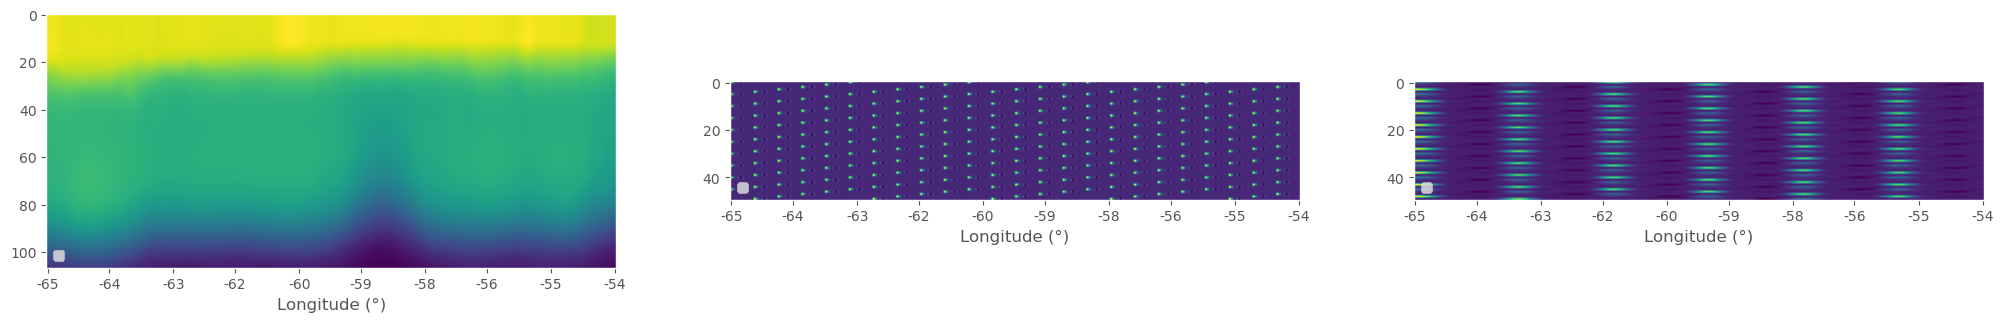

In [ ]:
# t,lat = 10,10

# fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

# im1 = axs[0].imshow(test_ssp_tens[t,:,lat,:], cmap=cmap, aspect = "equal")  
# im2 = axs[1].imshow(reduced_test_ssp_tens[t,:,lat,:], cmap=cmap, aspect = "equal")
# im3 = axs[2].imshow(reduced_pred_ssp_tens[t,:,lat,:], cmap=cmap, aspect = "equal")


# y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
# y_tick_values = depth_array[y_tick_indices]

# x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
# x_tick_values = coords["lon"].data[x_tick_indices]


# for ax in axs.flatten():
#         # ax.set_yticks(y_tick_indices)
#         # ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
#         ax.set_xticks(x_tick_indices)
#         ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])

#         ax.grid(False)
        
#         ax.set_xlabel("Longitude (°)")
#         ax.legend(loc = "lower left")
